In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact
from scipy import stats
import seaborn as sns

import matplotlib.font_manager as font_manager
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'

In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

In [2]:
count = np.array([5, 12])
nobs = np.array([83, 99])
stat, pval = proportions_ztest(count, nobs)

In [3]:
d50_counts = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/d50_countings_osvz_markers.tsv',sep='\t',index_col=0)

In [4]:
d50_counts

,vesicle,tx,gene,n_cells,n_DAPI,n_SOX2
exp,,,,,,
1,V1,SBN,SOX2+LIFR,81,1103,230
1,V2,SBN,SOX2+LIFR,15,289,97
1,V3,SBN,SOX2+LIFR,15,386,127
1,V4,SBN,SOX2+LIFR,38,668,159
1,V5,SBN,SOX2+LIFR,78,417,126
...,...,...,...,...,...,...
2,V1,SBNX,SOX2+HOPX,51,226,74
2,V2,SBNX,SOX2+HOPX,80,267,97
2,V3,SBNX,SOX2+HOPX,45,178,56


In [5]:
d50_counts['n_cells_per_DAPI'] = d50_counts['n_cells']/d50_counts['n_DAPI']
d50_counts['n_cells_per_SOX2'] = d50_counts['n_cells']/d50_counts['n_SOX2']

In [6]:
def ttest(a, b, axis=0, equal_var=True, nan_policy='propagate',
          alternative='two.sided'):        
    tval, pval = stats.ttest_ind(a=a, b=b, axis=axis, equal_var=equal_var,
                           nan_policy=nan_policy)
    if alternative == 'greater':
        if tval < 0:
            pval = 1 - pval / 2
        else:
            pval = pval / 2
    elif alternative == 'less':
        if tval < 0:
            pval /= 2
        else:
            pval = 1 - pval / 2
    else:
        assert alternative == 'two.sided'
    return tval, pval

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


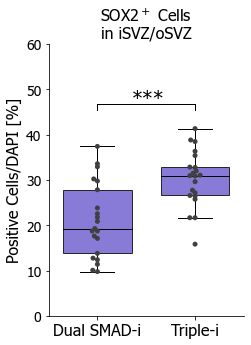

In [16]:
plt.figure(figsize=(3.5,5))

d50_counts_sub = d50_counts[d50_counts['gene'].isin(['TBR2','SOX2+PTPRZ1'])]
frac_pos_sbnx = d50_counts_sub[d50_counts_sub['tx']=='SBNX']['n_SOX2']/d50_counts_sub[d50_counts_sub['tx']=='SBNX']['n_DAPI']
frac_pos_sbn = d50_counts_sub[d50_counts_sub['tx']=='SBN']['n_SOX2']/d50_counts_sub[d50_counts_sub['tx']=='SBN']['n_DAPI']
d50_counts_sub['n_SOX2_per_DAPI'] = d50_counts_sub['n_SOX2']/d50_counts_sub['n_DAPI']

t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='two.sided')#,alternative='less')

ax = sns.boxplot(x="tx", y='n_SOX2_per_DAPI', data=d50_counts_sub,showfliers=False,color='white',
                linewidth=1,width=0.7)#,linecolor='black')
ax = sns.swarmplot(x="tx", y='n_SOX2_per_DAPI', data=d50_counts_sub, color=".25")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.ylabel('SOX2$^+$'+'/DAPI [%]',fontsize=20)
plt.ylabel('Positive Cells/DAPI [%]',fontsize=16)
plt.xlabel('')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('slateblue')
    box.set_alpha(0.8)

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         ax.lines[j].set_color('black')

plt.ylim(plt.ylim()[0],plt.ylim()[1]+(plt.ylim()[1]-plt.ylim()[0])*0.3)
y_cut = (plt.ylim()[1]-plt.ylim()[0])*0.03

y=max(max(frac_pos_sbnx),max(frac_pos_sbn))+y_cut*2
for j,idx in enumerate([[0,1]]):
    y_new = y+y_cut*2
    plt.plot([idx[0],idx[1]],[y_new,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[0],idx[0]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[1],idx[1]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    if p < 0.0001: star_t = '****'
    elif p < 0.001: star_t = '***'
    elif p < 0.01: star_t = '**'
    elif p < 0.05: star_t = '*'
    else: star_t = 'n.s.'
    if star_t == 'n.s.':
        plt.annotate(star_t,xy=(idx[0]+0.37*(idx[1]-idx[0]),y_new+0.005),fontsize=20)
    else:
        plt.annotate(star_t,xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.05,y_new),fontsize=20)

#max_val = np.math.ceil(max(max(frac_pos_sbnx),max(frac_pos_sbn))*10)
#print(max_val)
#plt.ylim(0,max_val*0.1)
#plt.ylim(0,30000)
#plt.ylim(plt.ylim()[0],plt.ylim()[1]+0.05)
plt.ylim(0,plt.ylim()[1])
plt.xticks([0,1],['Dual SMAD-i','Triple-i'],fontsize=16)
#plt.yticks([x*0.1 for x in np.linspace(0,max_val,max_val+1)],[x*0.1 for x in np.linspace(0,max_val,max_val+1)],fontsize=16)
plt.title('SOX2$^+$ Cells\nin iSVZ/oSVZ',fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks(plt.yticks()[0],[str(int(x*100)) for x in plt.yticks()[0]],fontsize=14)
plt.savefig('figures/sox2_per_osvz_area.with_points.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/sox2_per_osvz_area.with_points.pdf',bbox_inches='tight')

0.012666104212991207
0.007916665558731635
0.009267170658682634
0.010106001571091908
0.0032739706793309935


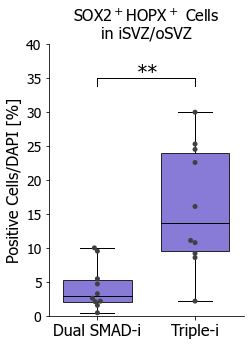

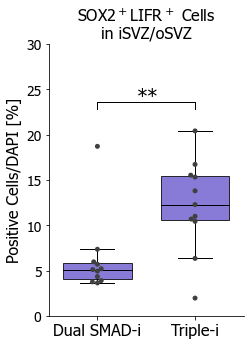

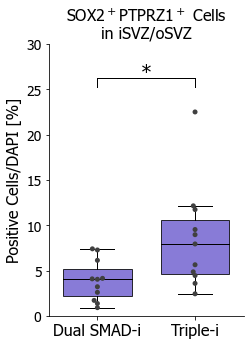

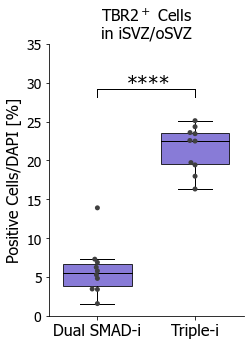

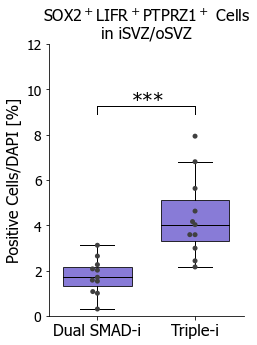

In [15]:
for gene in ['SOX2+HOPX','SOX2+LIFR','SOX2+PTPRZ1','TBR2','SOX2+LIFR+PTPRZ1']:
    
    '''
    plt.figure(figsize=(4,4))
    d50_counts_sub = d50_counts[d50_counts['gene']==gene]
    frac_pos_sbnx = d50_counts_sub[d50_counts_sub['tx']=='SBNX']['n_cells_per_DAPI']
    frac_pos_sbn = d50_counts_sub[d50_counts_sub['tx']=='SBN']['n_cells_per_DAPI']
    t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='less')
    t_w, p_w = stats.ranksums(frac_pos_sbnx, frac_pos_sbn)
    print(gene,p,p_w)
    
    ax = sns.boxplot(x="tx", y='n_cells_per_DAPI', data=d50_counts_sub)
    ax = sns.swarmplot(x="tx", y='n_cells_per_DAPI', data=d50_counts_sub, color=".25")
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_par ams(axis='both', which='major', labelsize=14)
    plt.xlabel('tx',fontsize=16)
    plt.ylabel('No. '+gene+' cells / DAPI',fontsize=16)
    plt.title(gene,fontsize=18)
    plt.show()
    '''
    
    plt.figure(figsize=(3.5,5))
    d50_counts_sub = d50_counts[d50_counts['gene']==gene]
    frac_pos_sbnx = d50_counts_sub[d50_counts_sub['tx']=='SBNX']['n_cells_per_DAPI']
    frac_pos_sbn = d50_counts_sub[d50_counts_sub['tx']=='SBN']['n_cells_per_DAPI']
    t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='two.sided')#,alternative='less')#
    
    ax = sns.boxplot(x="tx", y='n_cells_per_DAPI', data=d50_counts_sub,showfliers=False,color='white',
                    linewidth=1,width=0.7)#,linecolor='black')
    ax = sns.swarmplot(x="tx", y='n_cells_per_DAPI', data=d50_counts_sub, color=".25")
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    #plt.ylabel(''.join([x+'$^+$' for x in gene.split("+")])+'/DAPI [%]',fontsize=20)
    plt.ylabel('Positive Cells/DAPI [%]',fontsize=16)
    plt.xlabel('')

    # iterate over boxes
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('slateblue')
        box.set_alpha(0.8)

        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
             ax.lines[j].set_color('black')
    
    plt.ylim(plt.ylim()[0],plt.ylim()[1]+(plt.ylim()[1]-plt.ylim()[0])*0.3)
    y_cut = (plt.ylim()[1]-plt.ylim()[0])*0.03
    print(y_cut)
    y=max(max(frac_pos_sbnx),max(frac_pos_sbn))+y_cut*2
    for j,idx in enumerate([[0,1]]):
        y_new = y+y_cut*2
        plt.plot([idx[0],idx[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([idx[0],idx[0]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
        plt.plot([idx[1],idx[1]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        if star_t == 'n.s.':
            plt.annotate(star_t,xy=(idx[0]+0.37*(idx[1]-idx[0]),y_new+0.005),fontsize=20)
        else:
            plt.annotate(star_t,xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.05,y_new),fontsize=20)
    
    #max_val = np.math.ceil(max(max(frac_pos_sbnx),max(frac_pos_sbn))*10)
    #print(max_val)
    #plt.ylim(0,max_val*0.1)
    #plt.ylim(0,30000)
    #plt.ylim(plt.ylim()[0],plt.ylim()[1]+0.05)
    plt.ylim(0,plt.ylim()[1]*0.93)
    plt.xticks([0,1],['Dual SMAD-i','Triple-i'],fontsize=16)
    #plt.yticks([x*0.1 for x in np.linspace(0,max_val,max_val+1)],[x*0.1 for x in np.linspace(0,max_val,max_val+1)],fontsize=16)
    plt.title(''.join([x+'$^+$' for x in gene.split("+")])+' Cells\nin iSVZ/oSVZ',fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks(plt.yticks()[0],[str(int(x*100)) for x in plt.yticks()[0]],fontsize=14)
    #plt.savefig('figures/n_sox2_per_osvz_area.with_points.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/'+gene.replace("+","_")+'_per_osvz_area.with_points.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/'+gene.replace("+","_")+'_per_osvz_area.with_points.pdf',bbox_inches='tight')